In [17]:
import pandas as pd
import numpy as np
import yfinance as yf
import talib
import os


In [18]:
def tick_to_minute(df, freq="min"):
    """
    将Tick数据转换为分钟级OHLC数据
    :param tick_df: DataFrame, 需包含时间戳索引和price/volume列
    :param freq: 重采样频率（默认为1分钟）
    :return: 分钟级DataFrame
    """
    df = df.copy()
    df['datetime'] = pd.to_datetime(df['time'])
    df.set_index('datetime', inplace=True)

    # 2. 使用 resample 将 tick 数据转换为分钟级数据
    # 计算价格的 OHLC 以及成交量的总和
    df_minute = df.resample(freq).agg({
        'price': ['first', 'max', 'min', 'last'],
        'volume': 'sum',
        'InstrumentID':'first'
    })

    # 3. 整理列名称（可选）
    # df_minute.columns = ['_'.join(col).strip() for col in df_minute.columns.values]
    df_minute.columns = ['open', 'high', 'low', 'close', 'volume','InstrumentID']
    df_minute = df_minute.reset_index()
    
    # 处理空值
    df_minute = df_minute.dropna()  # 或填充：minute_df.ffill()
    
    return df_minute

In [62]:
# dirpath = 'FutSF_TickKZ_CTP_Daily_202301'
# direc = os.listdir(dirpath)

# wholef = pd.DataFrame()
# for file_name in direc:
#     if 'IF' not in file_name:
#         continue
#     df = pd.read_csv(os.path.join(dirpath,file_name), encoding='gbk')

#     f = df[['最新价','数量','合约代码']].copy()
#     f.columns = ['price','volume','InstrumentID']
#     f.loc[:,'time'] = pd.to_datetime(df['交易日'].astype(str) + ' ' + df['最后修改时间'])
#     ff = tick_to_minute(f, freq="min").iloc[1:-2,:]
#     wholef=pd.concat([wholef,ff],ignore_index=True)

dirpath = 'data/IF'
direc = os.listdir(dirpath)

wholef = pd.DataFrame()
for file_name in direc:

    df = pd.read_csv(os.path.join(dirpath,file_name), encoding='gbk')

    f = df[['LastPrice','Volume','InstrumentID']].copy()
    f.columns = ['price','volume','InstrumentID']
    f.loc[:,'time'] = pd.to_datetime(df['TradingDay'].astype(str) + ' ' + df['UpdateTime'])
    ff = tick_to_minute(f, freq="min").iloc[1:-2,:]
    wholef=pd.concat([wholef,ff],ignore_index=True)


In [63]:
wholef

,datetime,open,high,low,close,volume,InstrumentID
0,2023-03-02 09:29:00,4124.0,4124.0,4124.0,4124.0,146,IF2303
1,2023-03-02 09:30:00,4123.6,4129.4,4122.8,4129.4,115895,IF2303
2,2023-03-02 09:31:00,4129.4,4132.8,4129.2,4131.2,236006,IF2303
3,2023-03-02 09:32:00,4130.8,4131.6,4126.8,4131.6,316811,IF2303
4,2023-03-02 09:33:00,4130.8,4130.8,4127.4,4130.4,378076,IF2303
...,...,...,...,...,...,...,...
117369,2025-03-10 14:55:00,3918.8,3921.0,3918.8,3919.8,8460228,IF2503
117370,2025-03-10 14:56:00,3919.8,3920.0,3918.8,3918.8,8570607,IF2503
117371,2025-03-10 14:57:00,3918.8,3919.4,3918.4,3918.8,8830872,IF2503
117372,2025-03-10 14:58:00,3918.6,3919.4,3918.6,3918.8,8797342,IF2503


In [68]:
def abbretion_backtest(df, channel_period=20, atr_period=20, atr_multiplier = 2,add_threshold=0.5, stop_loss_mult=2, cost = 1):

    df = df.copy()
    
    # 计算 ATR（周期为 atr_period）
    df['ATR'] = pd.Series(talib.ATR(df['high'].values, df['low'].values, df['close'].values, timeperiod=atr_period)).shift(1)
    
    df['mvag'] = pd.Series(talib.SMA(df['close'].values, timeperiod=channel_period)).shift(1)
    
    # 初始化各列
    df['Signal'] = 0           # 信号：1 表示开多或加多，-1 表示开空或加空，0 表示平仓
    df['Position'] = 0         # 持仓数量（正数为多头，负数为空头）
    df['Trade_Price'] = np.nan # 当天发生交易时记录价格
    df['Cum_PnL'] = 0.0        # 累计盈亏
    
    position = 0             # 当前持仓数量
    entry_prices = []        # 记录每个入场单的价格（用于加仓及止损）
    last_entry = None        # 最近一次入场价格
    cumulative_pnl = 0.0
    trade_log = []           # 用于记录每笔交易详情
    
    # 从 channel_period 行开始遍历（前面数据不足无法计算通道）
    for i in range(channel_period, len(df)-1):
    
        current_date = df.index[i]
        close = df.iloc[i]['close']
        atr = df.iloc[i]['ATR']
        don_high = df.iloc[i]['mvag'] + atr_multiplier * atr
        don_low = df.iloc[i]['mvag'] - atr_multiplier * atr
        midline = df.iloc[i]['mvag']

        if df.iloc[i]['InstrumentID'] != df.iloc[i+1]['InstrumentID']:
            if position > 0:
                pnl = sum([close - price - cost for price in entry_prices])
                cumulative_pnl += pnl
                df.at[current_date, 'Signal'] = 0  # 平仓信号
                df.at[current_date, 'Trade_Price'] = close
                trade_log[-1].update({
                    'Exit_Date': current_date,
                    'Exit_Price': close,
                    'PnL': pnl
                })
                position = 0
                entry_prices = []
                last_entry = None
            elif position < 0:
                pnl = sum([price - close - cost for price in entry_prices])
                cumulative_pnl += pnl
                df.at[current_date, 'Signal'] = 0  # 平仓信号
                df.at[current_date, 'Trade_Price'] = close
                trade_log[-1].update({
                    'Exit_Date': current_date,
                    'Exit_Price': close,
                    'PnL': pnl
                })
                position = 0
                entry_prices = []
                last_entry = None
            
            df.at[current_date, 'Position'] = position
            df.at[current_date, 'Cum_PnL'] = cumulative_pnl

            continue


        
        # 如果关键指标未计算出来，则跳过
        if pd.isna(atr) or pd.isna(don_high) or pd.isna(don_low):
            df.at[current_date, 'Position'] = position
            df.at[current_date, 'Cum_PnL'] = cumulative_pnl
            continue
        
        # 无仓位时，判断入场信号
        if position == 0:
            if close > don_high:
                # 突破上轨，开多仓
                position = 1
                entry_prices = [close]
                last_entry = close
                df.at[current_date, 'Signal'] = 1
                df.at[current_date, 'Trade_Price'] = close
                trade_log.append({
                    'Entry_Date': current_date,
                    'Direction': 'Long',
                    'Entry_Prices': entry_prices.copy()
                })
            elif close < don_low:
                # 突破下轨，开空仓
                position = -1
                entry_prices = [close]
                last_entry = close
                df.at[current_date, 'Signal'] = -1
                df.at[current_date, 'Trade_Price'] = close
                trade_log.append({
                    'Entry_Date': current_date,
                    'Direction': 'Short',
                    'Entry_Prices': entry_prices.copy()
                })
        else:
            # 持仓中：判断加仓和止损
            if position > 0:  # 多仓逻辑
                # 加仓条件：当前价格比最近入场价格上涨超过 add_threshold × ATR
                if close >= last_entry + add_threshold * atr:
                    position += 1
                    entry_prices.append(close)
                    last_entry = close  # 更新最新入场价格
                    df.at[current_date, 'Signal'] = 1  # 表示加仓
                    df.at[current_date, 'Trade_Price'] = close
                    trade_log[-1]['Entry_Prices'] = entry_prices.copy()
                # 止损条件：当前价格低于最近入场价格减去 stop_loss_mult × ATR
                elif close <= last_entry - stop_loss_mult * atr:
                # elif close <= midline:
                    pnl = sum([close - price - cost for price in entry_prices])
                    cumulative_pnl += pnl
                    df.at[current_date, 'Signal'] = 0  # 平仓信号
                    df.at[current_date, 'Trade_Price'] = close
                    trade_log[-1].update({
                        'Exit_Date': current_date,
                        'Exit_Price': close,
                        'PnL': pnl
                    })
                    position = 0
                    entry_prices = []
                    last_entry = None
            elif position < 0:  # 空仓逻辑
                # 加仓条件：当前价格比最近入场价格下跌超过 add_threshold × ATR
                if close <= last_entry - add_threshold * atr:
                    position -= 1
                    entry_prices.append(close)
                    last_entry = close
                    df.at[current_date, 'Signal'] = -1  # 表示加仓
                    df.at[current_date, 'Trade_Price'] = close
                    trade_log[-1]['Entry_Prices'] = entry_prices.copy()
                # 止损条件：当前价格高于最近入场价格加上 stop_loss_mult × ATR
                elif close >= last_entry + stop_loss_mult * atr:
                # elif close >= midline:
                    pnl = sum([price - close - cost for price in entry_prices])
                    cumulative_pnl += pnl
                    df.at[current_date, 'Signal'] = 0  # 平仓信号
                    df.at[current_date, 'Trade_Price'] = close
                    trade_log[-1].update({
                        'Exit_Date': current_date,
                        'Exit_Price': close,
                        'PnL': pnl
                    })
                    position = 0
                    entry_prices = []
                    last_entry = None
                    
        # 记录当天的持仓和累计盈亏
        df.at[current_date, 'Position'] = position
        df.at[current_date, 'Cum_PnL'] = cumulative_pnl
    
    # 最后，在 for 循环结束后，若仍有未平仓仓位，则使用最后一根K线的价格平仓
    if position != 0:
        final_date = df.index[-1]
        final_price = df.iloc[-1]['close']
        if position > 0:
            pnl = sum([final_price - price - cost for price in entry_prices])
        else:
            pnl = sum([price - final_price - cost for price in entry_prices])
        cumulative_pnl += pnl
        # 更新最后一笔交易记录，标记为最终平仓
        if trade_log:
            trade_log[-1].update({
                'Exit_Date': final_date,
                'Exit_Price': final_price,
                'PnL': pnl
            })
        df.at[final_date, 'Signal'] = 0
        df.at[final_date, 'Trade_Price'] = final_price
        df.at[final_date, 'Position'] = 0
        df.at[final_date, 'Cum_PnL'] = cumulative_pnl
        position = 0
        entry_prices = []
        last_entry = None

    df.at[df.index[-1], 'Cum_PnL'] = cumulative_pnl
    return df, trade_log

In [69]:
result, trades = abbretion_backtest(wholef, channel_period=20, atr_period=20, atr_multiplier=2, add_threshold=0.5, stop_loss_mult=2.4)

# 输出最后几行回测结果
print(result.tail())

total_pnl = 0
# 输出交易记录
print("交易记录：")
for trade in trades:
    print(trade)
    total_pnl += trade.get('PnL', 0)
print(total_pnl)

                  datetime    open    high     low   close   volume  \
117369 2025-03-10 14:55:00  3918.8  3921.0  3918.8  3919.8  8460228   
117370 2025-03-10 14:56:00  3919.8  3920.0  3918.8  3918.8  8570607   
117371 2025-03-10 14:57:00  3918.8  3919.4  3918.4  3918.8  8830872   
117372 2025-03-10 14:58:00  3918.6  3919.4  3918.6  3918.8  8797342   
117373 2025-03-10 14:59:00  3919.0  3919.6  3917.8  3917.8  9086147   

       InstrumentID       ATR     mvag  Signal  Position  Trade_Price  Cum_PnL  
117369       IF2503  2.319138  3919.68       0         2          NaN -13626.6  
117370       IF2503  2.313181  3919.66       0         2          NaN -13626.6  
117371       IF2503  2.257522  3919.56       0         2          NaN -13626.6  
117372       IF2503  2.194646  3919.50       0         2          NaN -13626.6  
117373       IF2503  2.124913  3919.36       0         0       3917.8 -13632.0  
交易记录：
{'Entry_Date': 21, 'Direction': 'Long', 'Entry_Prices': [4137.6], 'Exit_Date': 40

In [70]:
maxholding = 0
winrate = 0
total_trades = 0
for trade in trades:
    maxholding = max(maxholding,len(trade['Entry_Prices']))
    total_trades += len(trade['Entry_Prices'])
    if trade.get('PnL', 0) > 0:
        winrate += len(trade['Entry_Prices'])
winrate = winrate/total_trades
winrate

0.3440337740959057

In [55]:
result.to_csv('result.csv',index=False)

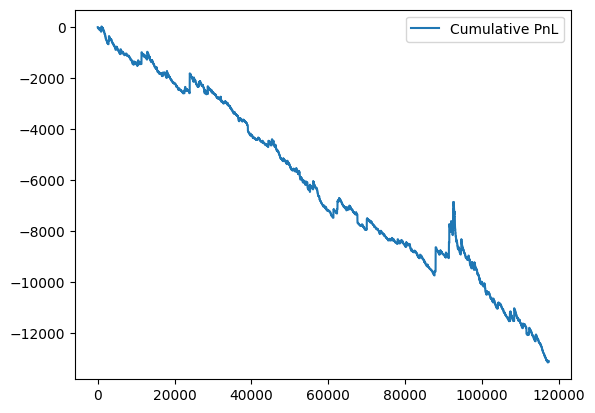

In [67]:
import matplotlib.pyplot as plt
# plt.plot(result['close'], label='Close Price')
# plt.plot(result['Donchian_High'], label='Donchian High')
# plt.plot(result['Donchian_Low'], label='Donchian Low')
plt.plot(result['Cum_PnL'], label='Cumulative PnL')
plt.legend()
plt.show()

In [26]:
dirpath = 'data/IC'
direc = os.listdir(dirpath)
ttpnl = []
wholef = pd.DataFrame()
for file_name in direc:

    df = pd.read_csv(os.path.join(dirpath,file_name), encoding='gbk')

    f = df[['LastPrice','Volume']].copy()
    f.columns = ['price','volume']
    f.loc[:,'time'] = pd.to_datetime(df['TradingDay'].astype(str) + ' ' + df['UpdateTime'])
    ff = tick_to_minute(f, freq="min").iloc[1:-4,:]

    result, trades = turtle_backtest(ff, channel_period=2, atr_period=2, add_threshold=0.1, stop_loss_mult=2.4)

    # 输出最后几行回测结果
    # print(result[['open', 'high', 'low', 'close', 'ATR', 'Donchian_High', 'Donchian_Low', 'Signal', 'Position', 'Cum_PnL']].tail())

    day_pnl = 0
    # 输出交易记录
    # print("交易记录：")
    for trade in trades:
        day_pnl += trade.get('PnL', 0)
    ttpnl.append(day_pnl)
    print(day_pnl,file_name)

KeyError: "Column(s) ['InstrumentID'] do not exist"

In [166]:
local_path = 'E:/ryse/LocalDatabase'
code = 'IM'
# os.makedirs(f'data/{code}', exist_ok=True)
f = pd.read_csv(local_path + '/' + code + '.csv')

f = f[f['Date'] >= 20230302].reset_index(drop=True)

for dt in range(len(f['Date'])):
    date = f['Date'][dt]
    filename = f'{code}_{date}.csv'
    if not os.path.exists(f'data/{code}/{filename}'):
        print(f'Not Processed {filename}')
    if date == 20230829:
        continue

Not Processed IM_20230322.csv
Not Processed IM_20230428.csv
Not Processed IM_20230814.csv
Not Processed IM_20230829.csv
Not Processed IM_20250311.csv
Not Processed IM_20250312.csv
Not Processed IM_20250313.csv
Not Processed IM_20250314.csv
Not Processed IM_20250317.csv


In [18]:
ff = 1
def func():
    ff = 2
func()
ff

1